# Environment

In [46]:
import pandas as pd
import gseapy as gp
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple
import numpy as np
import os

In [47]:
# Set the current working directory
os.chdir('/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_MECP2')

# Load data


In [48]:
DEA_NEU = pd.read_csv("DEA_NEU.csv", header=0)
DEA_NSC = pd.read_csv("DEA_NSC.csv", header=0)
DEA_NEU = DEA_NEU[DEA_NEU['padj'] < 0.05]
DEA_NSC = DEA_NSC[DEA_NSC['padj'] < 0.05]

In [49]:
DEA_NEU["Direction"] = np.where(DEA_NEU["log2FoldChange"] > 0, "UP", "DOWN")
DEA_NSC["Direction"] = np.where(DEA_NSC["log2FoldChange"] > 0, "UP", "DOWN")

In [50]:
DEA_NEU.head()

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Direction
10830,Etohd2,52.179960,-0.875472,0.325480,-2.689789,0.007150,0.049950,DOWN
10831,Prepl,6734.833093,-0.182629,0.067887,-2.690180,0.007141,0.049914,DOWN
10832,Slk,2299.724144,-0.235697,0.087604,-2.690482,0.007135,0.049914,DOWN
10833,Tomm34,630.507422,-0.309322,0.114977,-2.690304,0.007139,0.049914,DOWN
10834,Selenon,323.325362,-0.378338,0.140572,-2.691420,0.007115,0.049798,DOWN


In [51]:
mecp2_NEU = pd.read_csv("allgenes_NEU.csv", header=0)
mecp2_NSC = pd.read_csv("allgenes_NSC.csv", header=0)

# NEU - Ontology

In [52]:
# Load data
mecp2_df = mecp2_NEU
dea_df = DEA_NEU
output_prefix = 'enrichment_NEU'

In [53]:
# Get genes with exogenous MeCP2 binding
exog_genes = set(mecp2_df[mecp2_df['Exogenous_Promoter']]['gene'].tolist())

In [54]:
print(list(exog_genes)[:10])

['Kcnj6', 'Cdkl4', 'Lingo2', 'Esrrg', 'Crhr2', 'Tmsb10', 'Heg1', 'Tcerg1l', 'Fbxl16', 'Etl4']


In [55]:
# Get up and down-regulated genes from DEA
up_genes = set(dea_df[dea_df['Direction'] == 'UP']['gene'].tolist())
down_genes = set(dea_df[dea_df['Direction'] == 'DOWN']['gene'].tolist())
print(list(up_genes)[:10])
print(list(down_genes)[:10])

['Vwa1', 'Dmac1', 'Gm3365', 'Polr2c', 'Ntmt1', 'Riiad1', 'Shh', 'Pdia6', 'Ptma', 'Ndufv2']
['Kcnj6', 'Magi1', 'Asap2', 'Isoc1', '9330162G02Rik', 'Aak1', 'Cacnb2', 'Ank3', 'Sorcs3', 'Sox1']


In [56]:
# Get intersection of exogenous binding and DEA
exog_up = list(exog_genes.intersection(up_genes))
exog_down = list(exog_genes.intersection(down_genes))
print(len(exog_up))
print(list(exog_up)[:10])
print(len(exog_down))
print(list(exog_down)[:10])



29
['Eif2b3', 'Bend5', 'Gdf11', 'Crhr2', 'Fchsd1', 'Tmsb10', 'Pls3', 'Scube1', 'Gpr139', 'Tmem163']
51
['Kcnj6', 'Ryr2', 'Cdkl4', 'Megf11', 'Dcc', 'Lingo2', 'Lrrtm4', 'Arhgap29', 'Esrrg', 'Nyap2']


In [57]:
genes_dict = {
    'exog_up': exog_up,
    'exog_down': exog_down
}

In [58]:
def run_enrichment_analysis(gene_lists: Dict[str, List[str]], 
                          databases: List[str] = ['GO_Biological_Process_2021',
                                                'GO_Molecular_Function_2021',
                                                'GO_Cellular_Component_2021',
                                                'KEGG_2021_Human']) -> Dict[str, Dict]:
    """
    Perform enrichment analysis using multiple databases.
    
    Args:
        gene_lists: Dictionary of gene lists to analyze
        databases: List of databases to use for enrichment
        
    Returns:
        Dictionary containing enrichment results
    """
    results = {}
    
    for list_name, genes in gene_lists.items():
        list_results = {}
        
        for database in databases:
            # Run enrichment analysis
            enr = gp.enrichr(gene_list=genes,
                           gene_sets=database,
                           organism='Human',
                           outdir=None,
                           no_plot=True)
            
            # Store results
            list_results[database] = enr.results
            
        results[list_name] = list_results
    
    return results

In [59]:
results = run_enrichment_analysis(genes_dict)

In [60]:
print(results.keys())
print(results['exog_up'].keys())
print(results['exog_up']['KEGG_2021_Human'].head())

dict_keys(['exog_up', 'exog_down'])
dict_keys(['GO_Biological_Process_2021', 'GO_Molecular_Function_2021', 'GO_Cellular_Component_2021', 'KEGG_2021_Human'])
          Gene_set                                         Term Overlap  \
0  KEGG_2021_Human       D-Glutamine and D-glutamate metabolism     1/5   
1  KEGG_2021_Human                            Sulfur metabolism    1/10   
2  KEGG_2021_Human                        Arginine biosynthesis    1/22   
3  KEGG_2021_Human      Proximal tubule bicarbonate reclamation    1/23   
4  KEGG_2021_Human  Alanine, aspartate and glutamate metabolism    1/37   

    P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0  0.007230          0.237746            0                     0  178.276786   
1  0.014409          0.237746            0                     0   79.214286   
2  0.031435          0.270938            0                     0   33.928571   
3  0.032841          0.270938            0                     0   32.38

In [61]:
def filter_significant_results(results: Dict[str, Dict], 
                             adj_p_threshold: float = 0.05,
                             top_n: int = 10) -> Dict[str, Dict]:
    """
    Filter results for significant pathways and top hits.
    
    Args:
        results: Dictionary of enrichment results
        adj_p_threshold: Adjusted p-value threshold for significance
        top_n: Number of top pathways to keep
        
    Returns:
        Filtered results dictionary
    """
    filtered_results = {}
    
    for list_name, list_results in results.items():
        filtered_list_results = {}
        
        for database, df in list_results.items():
            # Filter for significant results
            significant = df[df['Adjusted P-value'] < adj_p_threshold].copy()
            
            # Sort by adjusted p-value and take top N
            significant = significant.sort_values('Adjusted P-value').head(top_n)
            
            if len(significant) > 0:
                filtered_list_results[database] = significant
                
        filtered_results[list_name] = filtered_list_results
    
    return filtered_results

In [62]:
filtered_results = filter_significant_results(results)

In [63]:
def plot_enrichment_results(filtered_results: Dict[str, Dict], 
                          output_prefix: str = 'enrichment'):
    """
    Create visualization plots for enrichment results.
    
    Args:
        filtered_results: Dictionary of filtered enrichment results
        output_prefix: Prefix for output files
    """
    for list_name, list_results in filtered_results.items():
        for database, df in list_results.items():
            if len(df) > 0:
                plt.figure(figsize=(12, 8))
                
                # Create bubble plot
                plt.scatter(-np.log10(df['Adjusted P-value']),
                          range(len(df)),
                          s=df['Odds Ratio'] * 50,
                          alpha=0.5)
                
                # Add pathway names
                plt.yticks(range(len(df)), df['Term'].str.slice(0, 50))
                
                plt.xlabel('-log10(Adjusted P-value)')
                plt.title(f'{list_name} - {database}')
                
                # Adjust layout
                plt.tight_layout()
                
                # Display plot in notebook
                plt.show()
                
                # Save plot
                # plt.savefig(f'{output_prefix}_{list_name}_{database}.png',
                #           bbox_inches='tight',
                #           dpi=300)
                plt.close()

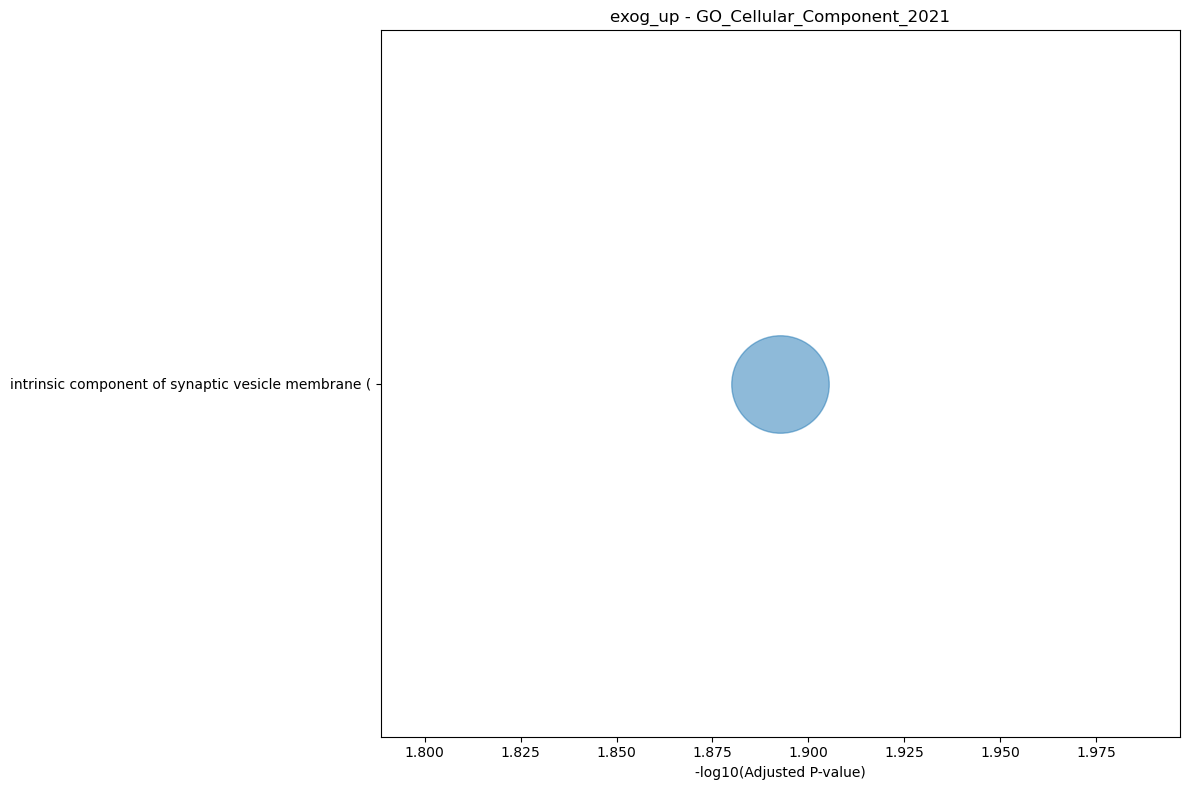

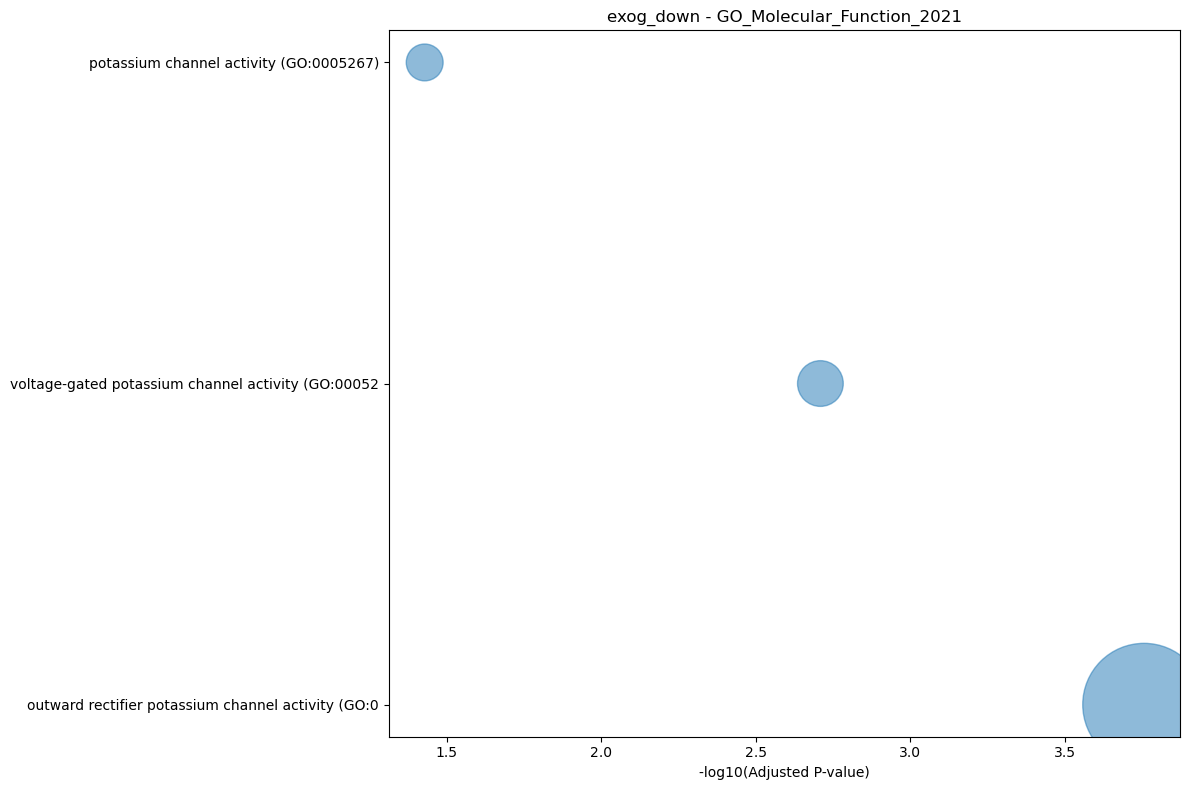

In [64]:
# Create plots
plot_enrichment_results(filtered_results, output_prefix=output_prefix)

In [65]:
# Save results to files
for list_name, list_results in filtered_results.items():
    for database, df in list_results.items():
        output_file = f'{output_prefix}_{list_name}_{database}.csv'
        df.to_csv(output_file, index=False)

# NSC - Ontology

In [66]:
mecp2_df = mecp2_NSC
dea_df = DEA_NSC
output_prefix = 'enrichment_NSC'

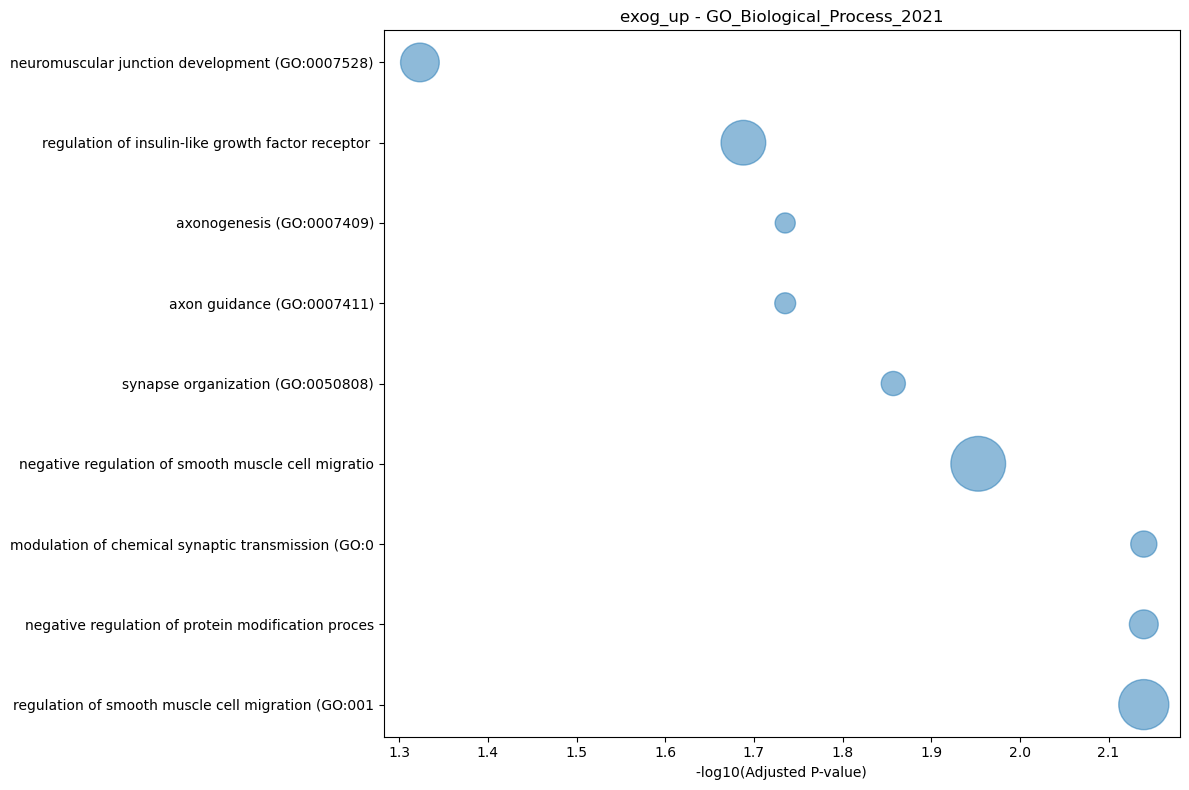

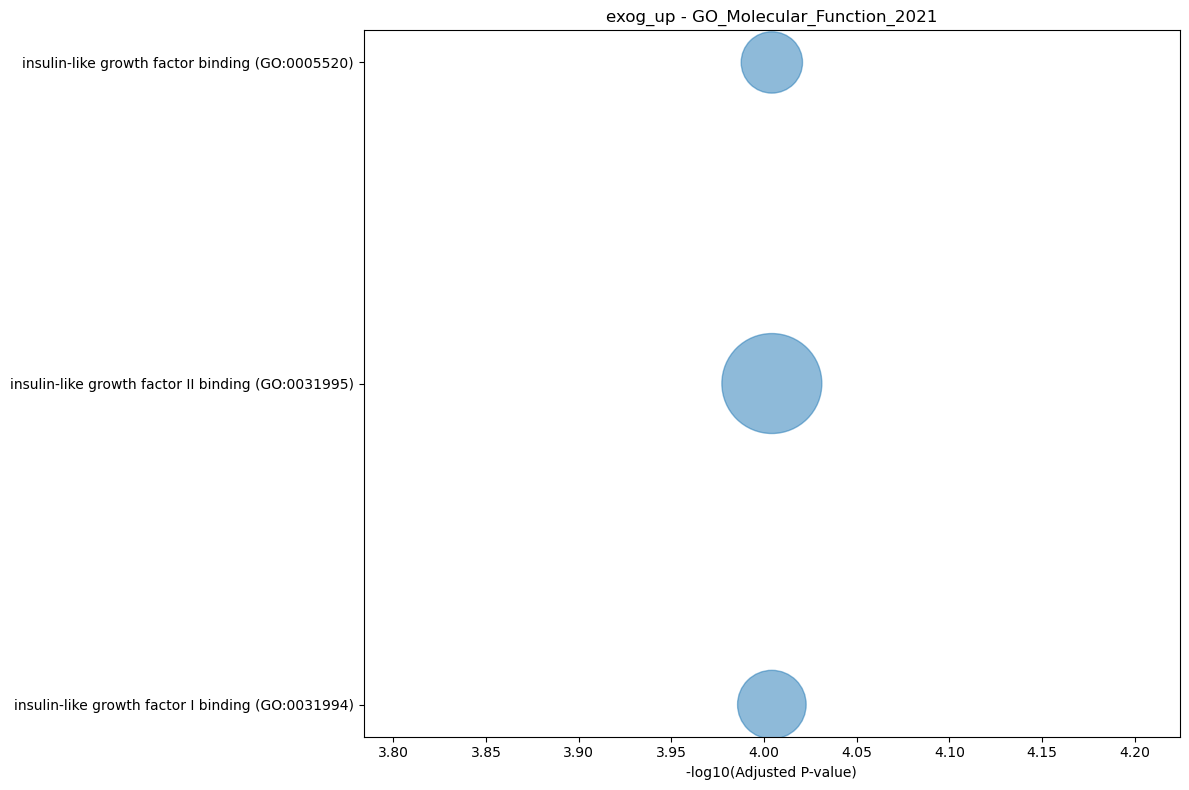

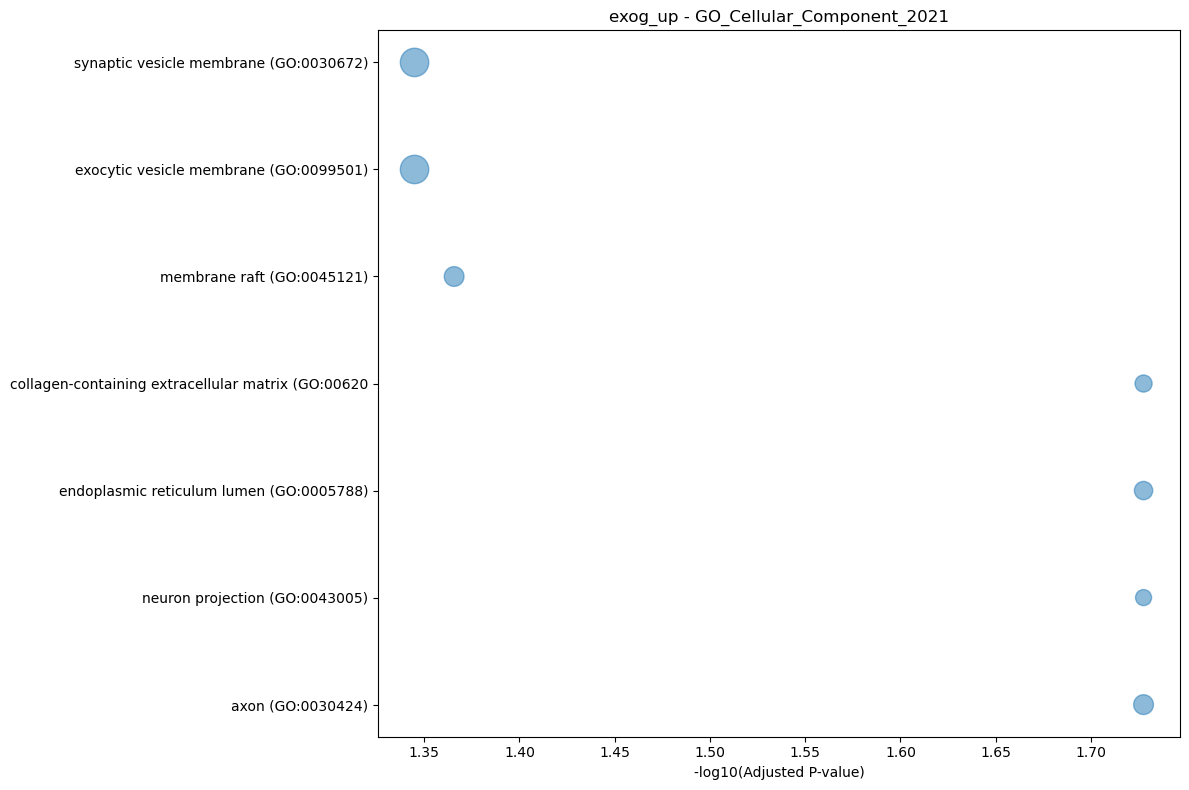

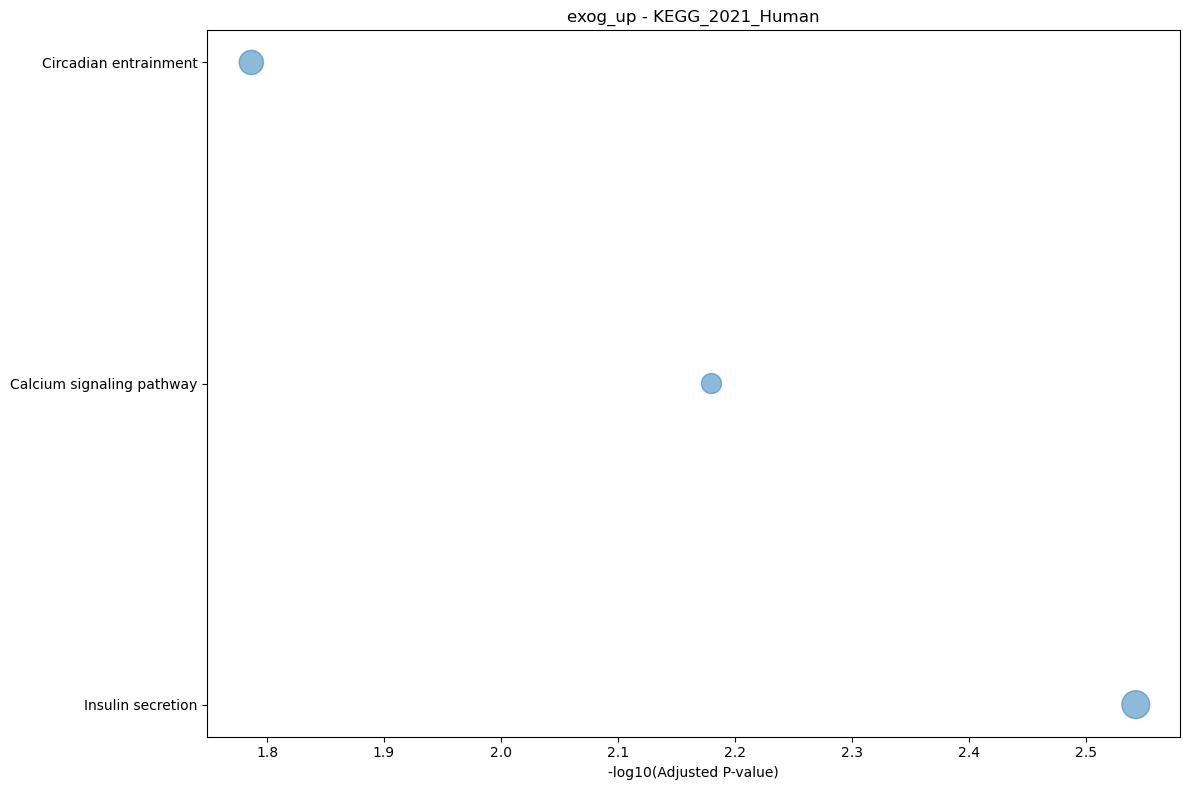

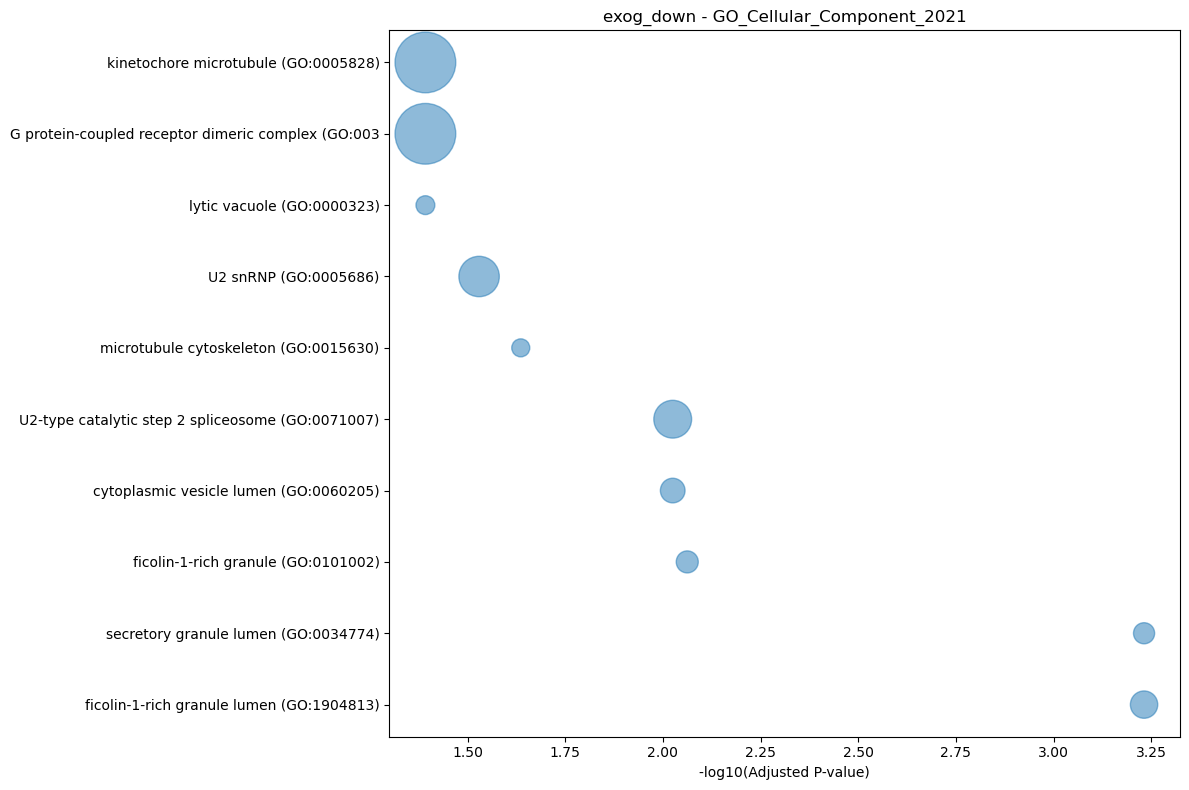

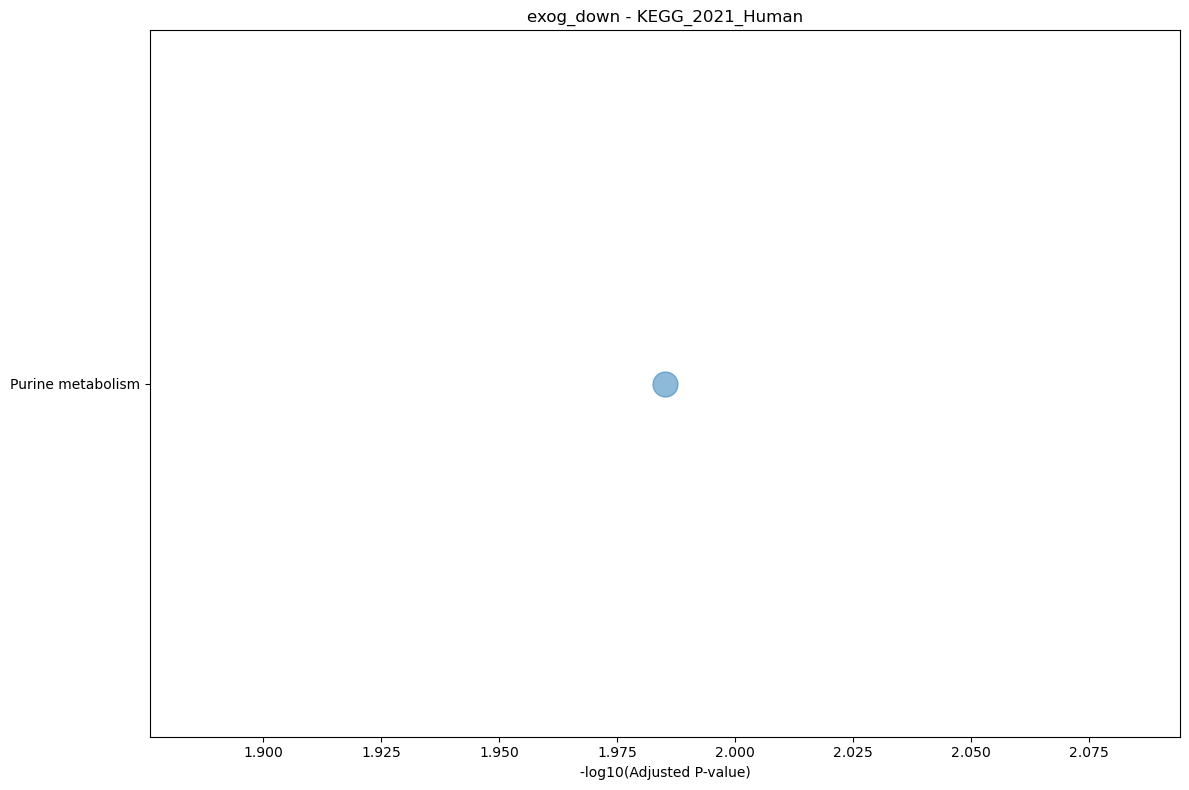

In [67]:
exog_genes = set(mecp2_df[mecp2_df['Exogenous_Promoter']]['gene'].tolist())
up_genes = set(dea_df[dea_df['Direction'] == 'UP']['gene'].tolist())
down_genes = set(dea_df[dea_df['Direction'] == 'DOWN']['gene'].tolist())
exog_up = list(exog_genes.intersection(up_genes))
exog_down = list(exog_genes.intersection(down_genes))

genes_dict = {
    'exog_up': exog_up,
    'exog_down': exog_down
}
results = run_enrichment_analysis(genes_dict)
filtered_results = filter_significant_results(results)
plot_enrichment_results(filtered_results, output_prefix=output_prefix)

In [68]:
# Save results to files
for list_name, list_results in filtered_results.items():
    for database, df in list_results.items():
        output_file = f'{output_prefix}_{list_name}_{database}.csv'
        df.to_csv(output_file, index=False)